<h1 align="center">Lab 2:  Sexism Identification in Twitter</h1>
<h2 align="center">Session 4. Transformers and Explainability</h2>
<h3 style="display:block; margin-top:5px;" align="center">Natural Language and Information Retrieval</h3>
<h3 style="display:block; margin-top:5px;" align="center">Degree in Data Science</h3>
<h3 style="display:block; margin-top:5px;" align="center">2024-2025</h3>    
<h3 style="display:block; margin-top:5px;" align="center">ETSInf. Universitat Politècnica de València</h3>
<br>

### Put your names here

- Víctor Máñez Poveda
- Marcos Valero Navarro

### CONSTANTS

In [ ]:
COLAB = True # IF YOU USE GOOGLE COLAB -> COLAB = True
PIP = False # IF YOU NEED INSTALL LIBRARIES -> PIP = True

**If you have trouble installing ferret-xai or jsonnet on Linux, try installing these packages first:**

- sudo apt install cmake   
- sudo apt install g++     
- sudo apt install make

**Or that after installing ferret-xai:**

- conda install -c conda-forge libstdcxx-ng --update-deps


## Some libraries

In [ ]:
if True:
    !pip install transformers --upgrade
    !pip  install datasets accelerate --upgrade
    !pip install ferret-xai --upgrade
    !pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C
^C


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple
import tqdm

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import torch

## Import readerEXIST2025 library, and read the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if COLAB is True:
  from google.colab import drive
  drive.mount('/content/drive')
  base_path = "/content/drive/MyDrive/LNR/"
else:
  base_path = "../"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
library_path = "/content/drive/MyDrive/EXIST_2025_Dataset_V0.2"
# library_path = "/content/drive/MyDrive/Lab_S2" #MARCOS VALERO
sys.path.append(library_path)
from readerEXIST2025 import EXISTReader

In [ ]:
# path to the dataset, adapt this path wherever you have the dataset
# library_path = "/content/drive/MyDrive/Lab_S2/EXIST_2025_Dataset_V0.2" #MARCOS VALERO
dataset_path = os.path.join(library_path, "../EXIST_2025_Dataset_V0.2/")

file_train = os.path.join(dataset_path, "EXIST2025_training.json")
file_dev = os.path.join(dataset_path, "EXIST2025_dev.json")

reader_train = EXISTReader(file_train)
reader_dev = EXISTReader(file_dev)

EnTrainTask1, EnDevTask1 = reader_train.get(lang="EN", subtask="1"), reader_dev.get(lang="EN", subtask="1")
SpTrainTask1, SpDevTask1 = reader_train.get(lang="ES", subtask="1"), reader_dev.get(lang="ES", subtask="1")

## Dataset class

In [ ]:
class SexismDataset(Dataset):
    def __init__(self, texts, labels, ids, tokenizer, max_len=128, pad="max_length", trunc=True,rt='pt'):
        self.texts = texts.tolist()
        self.labels = labels
        self.ids = ids
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad = pad
        self.trunc = trunc
        self.rt = rt

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,padding=self.pad, truncation=self.trunc,
            return_tensors=self.rt
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'id': torch.tensor(self.ids[idx], dtype=torch.long)
        }

## Auxiliary functions

In [ ]:
from collections import Counter # Counter counts the number of occurrences of each item
from itertools import tee, count

def uniquify(seq, suffs = count(1)):
    """Make all the items unique by adding a suffix (1, 2, etc).

    `seq` is mutable sequence of strings.
    `suffs` is an optional alternative suffix iterable.
    """
    not_unique = [k for k,v in Counter(seq).items() if v > 1] # so we have: ['name', 'zip']
    # suffix generator dict - e.g., {'name': <my_gen>, 'zip': <my_gen>}
    suff_gens = dict(zip(not_unique, tee(suffs, len(not_unique))))
    for idx,s in enumerate(seq):
        try:
            suffix = str(next(suff_gens[s]))
        except KeyError:
            # s was unique
            continue
        else:
            seq[idx] += suffix

def deduplicate(explanations):
    for i in range(len(explanations)):
        tokens = explanations[i].tokens
        uniquify(tokens, (f'_{x!s}' for x in range(1, 100)))
        explanations[i].tokens=tokens
    return explanations

In [ ]:
from transformers import  AutoTokenizer, AutoModelForSequenceClassification,  Trainer, TrainingArguments,  EarlyStoppingCallback

def compute_metrics_1(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_metrics_2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def sexism_classification_pipeline_task1(trainInfo, devInfo, testInfo=None, model_name='roberta-base', nlabels=2, ptype="single_label_classification", **args):
    # Model and Tokenizer
    labelEnc= LabelEncoder()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype
    )

    # Prepare datasets
    train_dataset = SexismDataset(trainInfo[1], labelEnc.fit_transform(trainInfo[2]),[int(x) for x in trainInfo[0]], tokenizer )
    val_dataset = SexismDataset(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    # Training Arguments
    training_args = TrainingArguments(
        report_to="none", # alt: "wandb", "tensorboard" "comet_ml" "mlflow" "clearml"
        output_dir= args.get('output_dir', './results'),
        num_train_epochs= args.get('num_train_epochs', 5),
        learning_rate=args.get('learning_rate', 5e-5),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 16),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 64),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay',0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 10),
        eval_strategy=args.get('eval_strategy','epoch'),
        save_strategy=args.get('save_strategy', "epoch"),
        load_best_model_at_end=args.get('load_best_model_at_end', True),
        metric_for_best_model=args.get('metric_for_best_model',"accuracy")
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_1,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience",3))]
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    # If there is a test dataset
    if testInfo is not None:
        # Prepare test dataset for prediction
        test_dataset = SexismDataset(testInfo[1], [0] * len(testInfo[1]),  [int(x) for x in testInfo[0]],   tokenizer)

        # Predict test set labels
        predictions = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=1)

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'id': testInfo[0],
            'label': labelEnc.inverse_transform(predicted_labels),
            "test_case": ["EXIST2025"]*len(predicted_labels)
        })
        submission_df.to_csv('sexism_predictions_task1.csv', index=False)
        print("Prediction for TASK 1 completed. Results saved to sexism_predictions_task1.csv")
        return model, submission_df
    return model, eval_results


def sexism_classification_pipeline_task2(trainInfo, devInfo, testInfo=None, model_name='bert-base-uncased', nlabels=3, ptype="single_label_classification", **args):
    # Model and Tokenizer
    labelEnc= LabelEncoder()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype
    )

    # Prepare datasets
    train_dataset = SexismDataset(trainInfo[1], labelEnc.fit_transform(trainInfo[2]),[int(x) for x in trainInfo[0]], tokenizer )
    val_dataset = SexismDataset(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    # Training Arguments
    training_args = TrainingArguments(
        report_to="none", # alt: "wandb", "tensorboard" "comet_ml" "mlflow" "clearml"
        output_dir= args.get('output_dir', './results'),
        num_train_epochs= args.get('num_train_epochs', 5),
        learning_rate=args.get('learning_rate', 5e-5),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 16),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 64),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay',0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 10),
        eval_strategy=args.get('eval_strategy','epoch'),
        save_strategy=args.get('save_strategy', "epoch"),
        save_total_limit=args.get('save_total_limit', 1),
        load_best_model_at_end=args.get('load_best_model_at_end', True),
        #metric_for_best_model=args.get('metric_for_best_model',"ICM")
        metric_for_best_model=args.get('metric_for_best_model',"f1")
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_2,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience",3))]
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    # If there is a test dataset
    if testInfo is not None:
        # Prepare test dataset for prediction
        test_dataset = SexismDataset(testInfo[1], [0] * len(testInfo[1]),  [int(x) for x in testInfo[0]],   tokenizer)

        # Predict test set labels
        predictions = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=1)

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'id': testInfo[0],
            'label': labelEnc.inverse_transform(predicted_labels),
            "test_case": ["EXIST2025"]*len(predicted_labels)

        })
        submission_df.to_csv('sexism_predictions_task2.csv', index=False)
        print("Prediction TASK2 completed. Results saved to sexism_predictions_task2.csv")
        return model, submission_df
    return model, eval_results

########################################################################################################################################
from peft import LoraConfig, get_peft_model, TaskType

def sexism_classification_pipeline_task1_LoRA(trainInfo, devInfo, testInfo=None, model_name='roberta-base', nlabels=2, ptype="single_label_classification", **args):
    # Model and Tokenizer
    labelEnc = LabelEncoder()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype
    )

    ######################################CHANGE###############################################
    # Configure LoRA
    lora_config = LoraConfig(
      task_type= args.get("task_type", TaskType.SEQ_CLS),
      target_modules= args.get("target_modules", ["query", "value"]),
      r= args.get("rank", 64),  # Rank of LoRA adaptation
      lora_alpha=args.get("lora_alpha", 32),  # Scaling factor
      lora_dropout=args.get("lora_dropout", 0.1),
      bias=args.get("bias", "none")
    )

    ######################################CHANGE###############################################
    # Prepare LoRA model
    peft_model = get_peft_model(model, lora_config)

    ###########################################################################################
    # Prepare datasets
    train_dataset = SexismDataset(trainInfo[1], labelEnc.fit_transform(trainInfo[2]),[int(x) for x in trainInfo[0]], tokenizer )
    val_dataset = SexismDataset(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    # Training Arguments
    training_args = TrainingArguments(
        report_to="none", # alt: "wandb", "tensorboard" "comet_ml" "mlflow" "clearml"
        output_dir= args.get('output_dir', './results_task1_LoRA0'),
        num_train_epochs= args.get('num_train_epochs', 10),
        learning_rate=args.get('learning_rate', 0.001),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 8),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 8),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay',0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 100),
        eval_strategy=args.get('eval_strategy','epoch'),
        save_strategy=args.get('save_strategy', "epoch"),
        save_total_limit=args.get('save_total_limit', 1),
        load_best_model_at_end=args.get('load_best_model_at_end', True),
        metric_for_best_model=args.get('metric_for_best_model',"f1")
    )

    # Initialize Trainer
    trainer = Trainer(
        ######################################CHANGE###############################################
        # Prepare LoRA model
        model=peft_model,
        ###########################################################################################
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_1,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience",3))]
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    ######################################CHANGE###############################################
    #Saving the new weigths for the LoRA model
    trainer.save_model('./final_best_model_LoRA')
    # Notice that, in this case only the LoRA matrices are saved.
    # The weigths for the classification head are not saved.
    ###########################################################################################

    ######################################CHANGE###############################################
    #Mixing the LoRA matrices with the weigths of the base model used
    mixModel = peft_model.merge_and_unload()
    mixModel.save_pretrained("./final_best_model_mixpeft")
    # IN this case the full model is saved.
    ###########################################################################################

    if testInfo is not None:
        # Prepare test dataset for prediction
        test_dataset = SexismDataset(testInfo[1], [0] * len(testInfo[1]),  [int(x) for x in testInfo[0]],   tokenizer)

        # Predict test set labels
        predictions = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=1)

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'id': testInfo[0],
            'label': labelEnc.inverse_transform(predicted_labels),
            "test_case": ["EXIST2025"]*len(predicted_labels)
        })
        submission_df.to_csv('sexism_predictions_task1.csv', index=False)
        print("Prediction for TASK 1 completed. Results saved to sexism_predictions_task1.csv")
        return model, submission_df
    return model, eval_results

# Two options to predict

### The simplest

In [ ]:
def predict_op1(model, dataset, args = {}):

    # Set up the Trainer, yes, a trainer for prediction!
    training_args = TrainingArguments(
        output_dir = "./output",
        per_device_eval_batch_size = args.get("per_device_eval_batch_size", 16),
        do_train=False,
        do_eval=False,
    )
    trainer = Trainer(model=model, args=training_args)

    # Predict
    predictions = trainer.predict(val_dataset)

    # Get logits, shape = #samples, num_classes (2)
    logits = predictions.predictions

    # Compute probability with softmax, requires logits to be tensors (unnecessary to compute the class)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    # Get the predicted class using argmax
    pred_classes = np.argmax(logits, axis=-1)
    # equals to: pred_classes = np.argmax(probs, axis=-1)

    # COMPLETE TO ALSO RETURN THE PROBABILITY OF THE PREDICTED CLASS
  ########################################################################################################
    # Probabilities of the predicted classes
    pred_probs = probs[np.arange(len(probs)), pred_classes]

    return pred_classes, pred_probs

### The coolest, if you know what you're doing

In [ ]:
#EnTrainTask1, EnDevTask1 = reader_train.get(lang="EN", subtask="1"), reader_dev.get(lang="EN", subtask="1")
#SpTrainTask1, SpDevTask1

device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

def predict_op2(model, dataset, args = {}):
    # batch_size
    batch_size = args.get("per_device_eval_batch_size", 16)

    model.to(device)
    # Set eval model, no gradient stored
    model.eval()

    # Prepare DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Prediction loop
    logits_list = []
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(dataloader):
            del batch["id"]
            batch = {k: v.to(device) for k, v in batch.items()}
            # equals to: outputs = model.forward(**batch)
            outputs = model(**batch)
            logits_list.append(outputs.logits)

    # Concatenate and move logits to the CPU, shape = #samples, num_classes (2)
    logits = torch.cat(logits_list, dim=0).cpu()

    # Compute probability with softmax, requires logits to be tensors (unnecessary to compute the class)
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()

    # Get the predicted class using argmax
    pred_classes = np.argmax(logits, axis=-1).numpy()
    # equals to: pred_classes = np.argmax(probs, axis=-1).numpy()

    # COMPLETE TO ALSO RETURN THE PROBABILITY OF THE PREDICTED CLASS
    pred_probs = probs[np.arange(len(probs)), pred_classes]

    return pred_classes, pred_probs


### Predictions from the best Spanish model

In [ ]:
# model_name = "pysentimiento/robertuito-base-uncased" # path to your best Spanish model
# params = {
#     # Configuración LoRA
#     "target_modules": ["query", "key", "value"],
#     "rank": 64,
#     "lora_alpha": 128,
#     "lora_dropout": 0.1,
#     "bias": "none",

#     # Hiperparámetros entrenamiento
#     "learning_rate": 3e-5,
#     "num_train_epochs": 5,
#     "per_device_train_batch_size": 16,
#     "per_device_eval_batch_size": 64,
#     "warmup_steps": 100,
#     "weight_decay": 0.01,
#     "early_stopping_patience": 2}

# model, eval_results = sexism_classification_pipeline_task1(EnTrainTask1, EnDevTask1, None, model_name, 2, "single_label_classification", **params )

In [ ]:
# from transformers import AutoModelForSequenceClassification

# # Modelo base sin fine-tuning específico para clasificación
# model_name = "pysentimiento/robertuito-base-uncased"

# # Lo cargamos como un modelo de clasificación (aunque el checkpoint solo es de lenguaje)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# # Mostramos los parámetros de la capa de clasificación
# print("\nCapa de clasificación añadida al modelo:")
# print(model.classifier)

# # Listamos sus pesos
# print("\nPesos de la capa classifier:")
# for name, param in model.classifier.named_parameters():
#     print(f"{name}: {param.shape} - requires_grad={param.requires_grad}")

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

def compute_metrics_1(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def sexism_classification_pipeline_task1_LoRA(trainInfo, devInfo, testInfo=None, model_name='roberta-base', nlabels=2, ptype="single_label_classification", **args):
    labelEnc = LabelEncoder()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype
    )

    lora_config = LoraConfig(
        task_type=args.get("task_type", TaskType.SEQ_CLS),
        target_modules=args.get("target_modules", ["query", "value"]),
        r=args.get("rank", 64),
        lora_alpha=args.get("lora_alpha", 32),
        lora_dropout=args.get("lora_dropout", 0.1),
        bias=args.get("bias", "none")
    )

    peft_model = get_peft_model(model, lora_config)

    train_dataset = SexismDataset(trainInfo[1], labelEnc.fit_transform(trainInfo[2]), [int(x) for x in trainInfo[0]], tokenizer)
    val_dataset = SexismDataset(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    training_args = TrainingArguments(
        report_to="none",
        output_dir=args.get('output_dir', './results_task1_LoRA0'),
        num_train_epochs=args.get('num_train_epochs', 10),
        learning_rate=args.get('learning_rate', 0.001),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 8),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 8),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay', 0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 100),
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='f1'
    )

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_1,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience", 3))]
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    trainer.save_model('/content/final_best_model_LoRA')
    mixModel = peft_model.merge_and_unload()
    mixModel.save_pretrained("/content/final_best_model_mixpeft")

    if testInfo is not None:
        test_dataset = SexismDataset(testInfo[1], [0] * len(testInfo[1]), [int(x) for x in testInfo[0]], tokenizer)
        predictions = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=1)

        submission_df = pd.DataFrame({
            'id': testInfo[0],
            'label': labelEnc.inverse_transform(predicted_labels),
            "test_case": ["EXIST2025"] * len(predicted_labels)
        })
        submission_df.to_csv('sexism_predictions_task1.csv', index=False)
        print("Prediction for TASK 1 completed. Results saved to sexism_predictions_task1.csv")
        return mixModel, submission_df

    return mixModel, eval_results

modelname_lora_robertuito = "pysentimiento/robertuito-base-uncased"
params = {
    # Entrenamiento
    "learning_rate": 1e-3,  # Más bajo para una convergencia más estable
    "num_train_epochs": 10,  # Más épocas pero con early stopping
    "per_device_train_batch_size": 64,  # Menor batch para más variación (ruido útil)
    "per_device_eval_batch_size": 64,
    "logging_steps" : 100
}
modelo, eval_results = sexism_classification_pipeline_task1_LoRA(SpTrainTask1, SpDevTask1, None, modelname_lora_robertuito, 2, "single_label_classification", **params )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.501280,0.781633,0.802947,0.773050,0.835249
2,0.553500,0.358627,0.840816,0.853933,0.835165,0.873563
3,0.553500,0.347962,0.851020,0.858801,0.867188,0.850575
4,0.364400,0.329031,0.859184,0.863366,0.893443,0.835249
5,0.364400,0.419181,0.816327,0.841549,0.778502,0.915709
6,0.283000,0.387711,0.853061,0.859375,0.876494,0.842912
7,0.283000,0.385499,0.840816,0.840816,0.899563,0.789272


Validation Results: {'eval_loss': 0.3290310502052307, 'eval_accuracy': 0.8591836734693877, 'eval_f1': 0.8633663366336634, 'eval_precision': 0.8934426229508197, 'eval_recall': 0.8352490421455939, 'eval_runtime': 3.3682, 'eval_samples_per_second': 145.48, 'eval_steps_per_second': 2.375, 'epoch': 7.0}


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

#Rutas ambos modelos, entrenado y fusionado
base_model = "pysentimiento/robertuito-base-uncased" # path to your best Spanish model
model_path = "final_best_model_mixpeft"

#Carga del tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(modelo)


#Dataset para la Validación
val_dataset = SexismDataset(SpDevTask1[1], LabelEncoder().fit_transform(SpDevTask1[2]), [int(x) for x in SpDevTask1[0]], tokenizer)

#Perdicciones del modelo
preds, probs = predict_op1(model, val_dataset)

# If you want to verify that both options do the same, try this:
#y_pred1, _ = predict_op1(model, val_dataset)
#y_pred2, _ = predict_op2(model, val_dataset)
#all(x1 == x2 for x1, x2 in zip(y_pred1, y_pred2))

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: vmaepov (vmaepov-universitat-polit-cnica-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Evaluation of the results

In [ ]:
def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary'
    )
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# Metrics
metrics = compute_metrics(val_dataset.labels, preds)
print("Metrics:", metrics)

# Confusion matrix
conf_matrix = confusion_matrix(val_dataset.labels, preds)#, labels=["NO", "YES"])
print("\nConfusion matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(val_dataset.labels, preds, target_names=["NO", "YES"], digits=4)
print("\nReport:")
print(class_report)

Metrics: {'accuracy': 0.8591836734693877, 'f1': 0.8633663366336634, 'precision': 0.8934426229508197, 'recall': 0.8352490421455939}

Confusion matrix:
[[203  26]
 [ 43 218]]

Report:
              precision    recall  f1-score   support

          NO     0.8252    0.8865    0.8547       229
         YES     0.8934    0.8352    0.8634       261

    accuracy                         0.8592       490
   macro avg     0.8593    0.8609    0.8591       490
weighted avg     0.8616    0.8592    0.8593       490



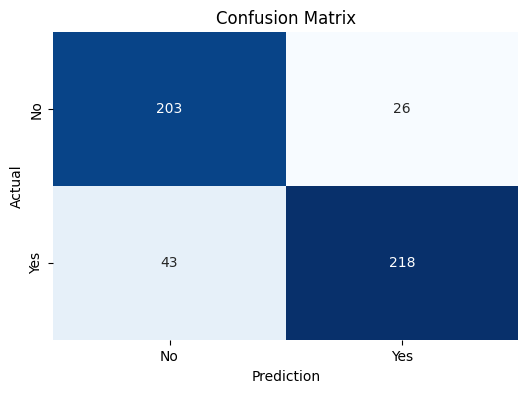

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

### Plot confusion matrix


### Text and probability of False positive and False negative

In [ ]:
from typing import List, Tuple

def false_positive_false_negative(
    y_true: List[int], y_pred: List[int], pred_probs: List[float], texts: List[str]
) -> Tuple[List[Tuple[float, str]], List[Tuple[float, str]]]:
    """
    Returns incorrect predictions from a binary classification model.

    Parameters:
    - y_true (list[int]): True labels for each sample (0 or 1).
    - y_pred (list[int]): Labels predicted by the model (0 or 1).
    - pred_probs (list[float]): Probabilities assigned by the model to the predicted class.
    - texts (list[str]): Text of each sample.

    Returns:
    - false_positives (list[tuple[float, str]]): List of tuples for false positives.
    - false_negatives (list[tuple[float, str]]): List of tuples for false negatives.
    Each tuple of both lists includes the probability and the text of the sample.
    """

    false_positive = []
    false_negative = []

    for yt, yp, prob, text in zip(y_true, y_pred, pred_probs, texts):
        if yt == 0 and yp == 1:
            false_positive.append((prob, text))
        elif yt == 1 and yp == 0:
            false_negative.append((prob, text))

    return false_positive, false_negative


In [ ]:
fpositive, fnegative = false_positive_false_negative(y_true = val_dataset.labels, y_pred = preds, pred_probs = probs, texts = val_dataset.texts)

print("False positive:", len(fpositive))
for s in fpositive:
    print('**', s)

print("\n\nFalse negative:", len(fnegative))
for s in fnegative:
    print('**', s)

False positive: 26
** (0.9407638, 'Agarré un desodorante sin querer que se llama Patrichs y pensé que decía Patriarchy jajsjsj olor a VARON')
** (0.62741506, '#Kentucky se convirtió en el primer estado que deja de practicar #abortos en sus #clínicas.Para leer más, siga el link:https://t.co/mmnkE9manm #abortionban #derechosdelamujer #womensrights https://t.co/xQvQZSIkYM')
** (0.68215925, 'El proyecto tiene como nombre “Acción empresarial en la prevención de violencia de género y acoso sexual laboral”, empezará el 24 de mayo, y pueden inscribirse de forma gratuita, todas las empresas medianas o grandes que firmen un acuerdo de compromiso https://t.co/FYCEsIWtmH')
** (0.92590266, '@Not_TsundereZ CalvoAh diablos no me denuncies por acoso sexual 😭😭Pero fuera bromas, que tiene que ver una cosa con la otra yo tampoco entiendo nada tiene sentido https://t.co/W2ErmEVqQt')
** (0.61797184, 'Hermanas no se conformen con mediocridades, el amor romantico si existe Y LO COMPROBE')
** (0.6812974, '@Di

In [ ]:
fpositive, fnegative = false_positive_false_negative(y_true = val_dataset.labels, y_pred = preds, pred_probs = probs, texts = val_dataset.texts)

print("False positive:", len(fpositive))
for s in fpositive:
    print('**', s)

print("\n\nFalse negative:", len(fnegative))
for s in fnegative:
    print('**', s)

False positive: 26
** (0.9407638, 'Agarré un desodorante sin querer que se llama Patrichs y pensé que decía Patriarchy jajsjsj olor a VARON')
** (0.62741506, '#Kentucky se convirtió en el primer estado que deja de practicar #abortos en sus #clínicas.Para leer más, siga el link:https://t.co/mmnkE9manm #abortionban #derechosdelamujer #womensrights https://t.co/xQvQZSIkYM')
** (0.68215925, 'El proyecto tiene como nombre “Acción empresarial en la prevención de violencia de género y acoso sexual laboral”, empezará el 24 de mayo, y pueden inscribirse de forma gratuita, todas las empresas medianas o grandes que firmen un acuerdo de compromiso https://t.co/FYCEsIWtmH')
** (0.92590266, '@Not_TsundereZ CalvoAh diablos no me denuncies por acoso sexual 😭😭Pero fuera bromas, que tiene que ver una cosa con la otra yo tampoco entiendo nada tiene sentido https://t.co/W2ErmEVqQt')
** (0.61797184, 'Hermanas no se conformen con mediocridades, el amor romantico si existe Y LO COMPROBE')
** (0.6812974, '@Di

### Select some samples to analyze

You can select the samples with more confidence, those with less confidence, a mix of both, or simply the ones you consider more interesting.



**Try not to choose the same samples that I’ve selected, and Justify your decision**.


In [ ]:
# COMPLETE !
fpositive_samples = [
    'Beber daña las neuronas sr. Puente, a quienes les queden claro! [...] La costumbre social comunista!',
    'La intensidad tiene mala fama en estos tiempos de amor líquido. [...]',
    '@Pajaropolitico @lopezobrador_ @GobiernoMX Que no vaya, recuerdan que la última vez en la @ONU_es nos avergonzó?...',
    '@caderas_blancas Uhh que bajón menos mal que te tienen a vos!']

fnegative_samples = [
    'Este cabron has sexually harassed women and girls en el community y cuando es confrontado [...]',
    'Típica falta de respeto hacia mujeres profesionales [...]',
    'Ayer fuimos a un antro gay y todo hermoso. Hasta que a dos se les ocurrió acosar y pelear por una morrita [...]',
    'De los asuntos más complicados de mi trabajo es el mansplaining. Algunos políticos [...]'
]


In [ ]:
# !pip install ferret
!pip install -U ferret-xai
from ferret import Benchmark
from IPython.display import display_html

# selecting the benchmark
bench = Benchmark(model, tokenizer)#, explainers=[s,l])
# If you have trouble with this benchmark (runtime errors), try using just those two explainers.
# from ferret.explainers.shap import SHAPExplainer
# from ferret.explainers.lime import LIMEExplainer
# lexp = LIMEExplainer(model, tokenizer)
# sexp = SHAPExplainer(model, tokenizer)
# bench = Benchmark(model, tokenizer, explainers=[sexp,lexp])

def explain_this(benchmark, sentence, target):
    explanations = benchmark.explain(sentence, target=target)
    explanations_de = deduplicate(explanations)
    explanation_evaluations = benchmark.evaluate_explanations(explanations_de, target=target)
    print("Sentence:", sentence)
    print("Class:", target)
    tble = benchmark.show_table(explanations_de)
    tble2 = benchmark.show_evaluation_table(explanation_evaluations)
    display_html(tble.to_html(), raw=True)
    display_html(tble2.to_html(), raw=True)

### Show explanations

In [ ]:
for sample in fpositive_samples:
    print("False Positive:")
    explain_this(bench, sample, 1)
    print("\n\n")

for sample in fnegative_samples:
    print("False Negative:")
    explain_this(bench, sample, 0)
    print("\n\n")

False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Beber daña las neuronas sr. Puente, a quienes les queden claro! [...] La costumbre social comunista!
Class: 1


Token,▁beber,▁daña,▁las,▁neuronas,▁sr.,▁pu,"ente,",▁a,▁quienes,▁les,▁queden,▁claro!,▁[,...],▁la,▁costumbre,▁social,▁comunista,!
Partition SHAP,0.01,-0.09,0.13,-0.00,0.00,-0.03,-0.01,-0.01,-0.10,0.11,0.02,-0.17,-0.01,0.04,0.09,-0.02,-0.02,0.11,-0.02
LIME,-0.08,-0.11,-0.02,0.07,-0.00,-0.04,-0.04,0.02,-0.11,0.08,0.02,-0.10,-0.08,0.01,0.03,-0.02,0.01,0.07,-0.08
Gradient,0.11,0.10,0.02,0.11,0.06,0.04,0.05,0.01,0.02,0.01,0.04,0.05,0.03,0.06,0.01,0.09,0.05,0.10,0.01
Gradient (x Input),0.07,-0.02,-0.01,-0.21,-0.03,0.05,-0.07,-0.01,-0.05,-0.01,0.06,-0.02,-0.03,-0.01,0.02,0.07,-0.10,0.07,0.01
Integrated Gradient,0.08,-0.01,-0.06,-0.09,-0.09,-0.01,0.06,-0.07,-0.02,-0.06,-0.00,-0.04,-0.03,-0.00,0.08,-0.02,0.05,-0.03,0.05
Integrated Gradient (x Input),0.09,0.06,0.05,0.09,0.03,0.07,0.05,0.08,0.05,0.07,0.06,0.04,0.04,0.03,0.06,0.04,0.03,0.04,0.03


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.01,-0.70,0.32
LIME,0.01,-0.56,0.40
Gradient,-0.27,-0.17,-0.10
Gradient (x Input),-0.08,-0.41,-0.01
Integrated Gradient,-0.03,-0.47,0.06
Integrated Gradient (x Input),-0.14,-0.23,-0.09





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: La intensidad tiene mala fama en estos tiempos de amor líquido. [...]
Class: 1


Token,▁la,▁intensidad,▁tiene,▁mala,▁fama,▁en,▁estos,▁tiempos,▁de,▁amor,▁líqui,do.,▁[,...]
Partition SHAP,0.10,-0.14,0.09,0.13,0.05,0.05,-0.04,-0.04,-0.07,-0.03,-0.03,-0.05,-0.06,0.11
LIME,0.08,-0.22,-0.02,0.03,0.15,0.00,0.04,-0.12,-0.03,-0.04,-0.15,0.06,-0.04,0.02
Gradient,0.02,0.24,0.03,0.05,0.12,0.01,0.02,0.05,0.01,0.04,0.14,0.03,0.08,0.13
Gradient (x Input),-0.00,-0.01,-0.05,-0.02,-0.10,-0.02,-0.04,-0.22,-0.00,-0.05,0.07,-0.01,-0.09,-0.32
Integrated Gradient,-0.06,-0.05,0.10,-0.02,0.01,0.03,-0.00,-0.08,0.05,0.06,-0.05,0.08,0.10,0.07
Integrated Gradient (x Input),0.09,0.00,0.06,0.12,0.10,0.15,0.06,0.11,-0.00,0.05,0.05,0.06,0.06,0.08


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.02,-0.57,0.38
LIME,0.00,-0.40,0.41
Gradient,-0.27,-0.22,0.08
Gradient (x Input),0.00,-0.43,-0.08
Integrated Gradient,-0.03,-0.28,-0.08
Integrated Gradient (x Input),-0.10,-0.31,0.27





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @Pajaropolitico @lopezobrador_ @GobiernoMX Que no vaya, recuerdan que la última vez en la @ONU_es nos avergonzó?...
Class: 1


Token,▁_1,@_1,pa,jar,opol,it,ico,▁_2,@_2,lo,pez,o,bra,dor,__1,▁_3,@_3,gobierno,mx,▁que_1,▁no,"▁vaya,",▁recuerdan,▁que_2,▁la_1,▁última,▁vez,▁en,▁la_2,▁_4,@_4,on,u,__2,es,▁nos,▁avergon,zó,?...
Partition SHAP,-0.00,-0.00,-0.01,-0.01,0.00,0.00,-0.01,0.00,-0.04,0.05,0.08,-0.03,-0.02,-0.03,-0.02,-0.00,-0.01,-0.01,-0.02,0.01,0.01,0.04,-0.01,0.05,0.07,-0.03,-0.07,-0.01,0.03,0.00,-0.01,-0.01,0.01,-0.04,-0.03,-0.06,0.07,0.06,-0.01
LIME,-0.02,0.05,0.02,0.01,-0.02,0.00,-0.03,-0.00,0.01,-0.02,0.01,-0.02,-0.01,-0.02,-0.02,-0.00,0.01,-0.02,-0.06,0.02,0.00,0.04,-0.03,0.02,0.02,-0.04,-0.06,-0.02,0.05,-0.01,0.02,-0.03,0.00,-0.03,-0.00,-0.09,0.08,-0.03,0.04
Gradient,0.01,0.03,0.02,0.02,0.04,0.01,0.01,0.01,0.03,0.01,0.03,0.02,0.04,0.02,0.02,0.00,0.03,0.03,0.03,0.01,0.01,0.05,0.05,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.04,0.02,0.01,0.01,0.01,0.02,0.14,0.05,0.06
Gradient (x Input),-0.01,0.03,-0.02,0.03,0.06,0.01,-0.01,-0.01,0.02,0.01,0.04,0.03,-0.08,0.01,-0.02,0.00,0.02,0.02,0.04,0.00,-0.01,-0.04,-0.08,0.01,0.00,-0.02,-0.03,-0.00,0.00,0.00,0.03,0.00,-0.03,-0.04,0.00,0.03,0.06,0.11,0.02
Integrated Gradient,0.01,-0.01,-0.05,-0.03,-0.05,0.01,0.02,-0.02,0.02,-0.02,-0.02,0.00,-0.00,0.00,0.05,-0.03,0.07,-0.01,0.02,-0.02,-0.01,0.05,0.02,-0.01,-0.02,-0.01,-0.03,0.00,-0.01,0.05,0.01,-0.01,-0.01,-0.01,-0.01,0.01,-0.00,-0.04,0.04
Integrated Gradient (x Input),0.04,0.08,0.01,-0.01,-0.03,-0.03,-0.02,0.04,0.00,-0.01,0.03,0.01,-0.01,-0.02,0.01,0.02,0.04,-0.05,-0.03,0.03,0.02,0.02,0.08,-0.02,0.01,0.03,0.01,-0.01,0.04,0.03,0.05,-0.00,0.03,0.01,-0.01,0.01,0.07,-0.04,-0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.01,-0.49,0.39
LIME,0.01,-0.46,0.47
Gradient,-0.09,-0.05,-0.15
Gradient (x Input),-0.01,-0.06,-0.02
Integrated Gradient,-0.03,-0.01,0.01
Integrated Gradient (x Input),-0.00,-0.14,0.19





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @caderas_blancas Uhh que bajón menos mal que te tienen a vos!
Class: 1


Token,▁,@,ca,deras,_,blan,cas,▁u,hh,▁que_1,▁bajón,▁menos,▁mal,▁que_2,▁te,▁tienen,▁a,▁vos!
Partition SHAP,-0.13,-0.12,0.01,0.04,0.01,0.11,0.11,0.04,0.07,0.08,-0.10,0.00,0.03,0.04,0.03,0.02,0.01,0.05
LIME,-0.04,-0.07,-0.01,0.02,-0.08,0.16,0.09,0.05,0.07,0.04,-0.17,0.02,0.07,0.07,0.03,0.00,0.01,0.01
Gradient,0.02,0.13,0.04,0.09,0.05,0.11,0.08,0.03,0.04,0.02,0.17,0.02,0.02,0.01,0.02,0.04,0.01,0.06
Gradient (x Input),0.03,0.11,0.02,-0.02,0.01,-0.14,-0.10,-0.05,-0.05,-0.02,0.16,-0.03,0.02,-0.00,-0.05,0.08,0.03,-0.04
Integrated Gradient,0.06,0.05,0.07,0.06,-0.03,0.05,0.12,-0.04,0.03,0.04,-0.04,0.02,-0.07,-0.01,0.01,0.10,-0.01,0.04
Integrated Gradient (x Input),0.09,0.07,0.04,0.03,0.04,0.12,0.02,0.03,0.11,0.10,-0.01,0.00,0.08,0.06,0.08,0.04,0.04,0.04


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.15,-0.43,0.35
LIME,0.19,-0.40,0.32
Gradient,-0.18,-0.02,0.02
Gradient (x Input),-0.49,0.05,-0.37
Integrated Gradient,0.12,-0.12,-0.03
Integrated Gradient (x Input),-0.11,-0.18,0.05





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Este cabron has sexually harassed women and girls en el community y cuando es confrontado [...]
Class: 0


Token,▁este,▁cabron,▁has,▁sexual,ly,▁har,as,sed,▁women,▁and,▁girls,▁en,▁el,▁community,▁y,▁cuando,▁es,▁confron,tado,▁[,...]
Partition SHAP,-0.02,-0.00,-0.05,-0.16,-0.01,0.00,-0.07,-0.04,-0.35,-0.05,-0.01,0.01,-0.04,0.06,-0.02,-0.00,-0.01,0.00,0.00,0.01,-0.06
LIME,0.00,-0.01,-0.03,-0.27,0.02,-0.01,-0.11,-0.02,-0.24,0.01,-0.10,-0.02,-0.03,-0.00,-0.02,0.00,-0.01,0.02,0.00,-0.03,-0.06
Gradient,0.03,0.08,0.05,0.09,0.03,0.04,0.02,0.04,0.11,0.03,0.11,0.01,0.01,0.07,0.01,0.01,0.01,0.09,0.02,0.04,0.06
Gradient (x Input),-0.02,0.13,0.08,0.19,-0.03,0.07,-0.01,-0.00,0.03,0.01,0.10,-0.02,-0.02,0.05,-0.01,-0.01,-0.02,-0.03,0.02,0.04,0.11
Integrated Gradient,-0.01,0.13,-0.01,-0.04,-0.04,0.03,0.07,-0.03,-0.00,0.00,0.02,-0.01,-0.04,-0.04,-0.05,0.00,-0.05,0.00,-0.10,0.03,-0.05
Integrated Gradient (x Input),0.09,-0.18,0.05,-0.10,-0.05,-0.03,-0.05,-0.05,-0.13,-0.00,-0.07,-0.01,0.01,0.01,0.02,0.01,0.02,-0.02,0.01,-0.05,-0.02


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.04,-0.77,0.39
LIME,0.03,-0.73,0.33
Gradient,-0.74,-0.07,0.03
Gradient (x Input),-0.44,-0.24,0.01
Integrated Gradient,0.00,-0.45,0.23
Integrated Gradient (x Input),-0.03,-0.77,-0.01





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Típica falta de respeto hacia mujeres profesionales [...]
Class: 0


Token,▁típica,▁falta,▁de,▁respeto,▁hacia,▁mujeres,▁profesionales,▁[,...]
Partition SHAP,-0.09,-0.11,-0.07,0.04,-0.01,-0.49,0.05,0.01,-0.10
LIME,-0.10,-0.03,-0.01,0.05,-0.01,-0.69,0.06,0.01,-0.04
Gradient,0.13,0.05,0.01,0.08,0.06,0.17,0.21,0.08,0.15
Gradient (x Input),0.22,-0.03,-0.01,-0.04,-0.05,0.29,-0.12,-0.03,0.20
Integrated Gradient,-0.08,-0.00,0.02,0.11,-0.07,0.39,0.08,0.13,0.09
Integrated Gradient (x Input),-0.16,-0.03,-0.09,-0.11,0.16,-0.37,-0.05,0.01,-0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.00,-0.55,0.83
LIME,0.00,-0.55,0.78
Gradient,-0.61,-0.19,0.00
Gradient (x Input),-0.93,-0.42,-0.56
Integrated Gradient,-0.63,-0.43,0.17
Integrated Gradient (x Input),0.01,-0.48,0.39





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Ayer fuimos a un antro gay y todo hermoso. Hasta que a dos se les ocurrió acosar y pelear por una morrita [...]
Class: 0


Token,▁ayer,▁fuimos,▁a_1,▁un,▁antro,▁gay,▁y_1,▁todo,▁hermoso.,▁hasta,▁que,▁a_2,▁dos,▁se,▁les,▁ocurrió,▁acos,ar,▁y_2,▁pelear,▁por,▁una,▁mor,rita,▁[,...]
Partition SHAP,0.02,0.00,-0.02,0.02,0.01,-0.09,-0.02,-0.00,0.02,-0.01,-0.00,-0.01,-0.02,0.00,-0.04,0.02,-0.21,-0.11,-0.05,-0.06,-0.01,-0.09,-0.03,-0.01,0.01,-0.11
LIME,0.03,0.02,-0.01,-0.00,-0.01,-0.14,-0.01,-0.03,0.06,0.01,-0.02,-0.01,-0.03,0.01,-0.04,-0.01,-0.20,-0.04,-0.01,-0.07,-0.03,-0.06,-0.09,0.03,-0.03,-0.00
Gradient,0.02,0.03,0.01,0.01,0.12,0.11,0.01,0.01,0.04,0.01,0.01,0.01,0.02,0.01,0.01,0.06,0.10,0.03,0.01,0.08,0.01,0.02,0.06,0.07,0.04,0.07
Gradient (x Input),-0.02,0.01,-0.00,-0.00,-0.07,0.05,-0.00,-0.00,0.06,0.00,0.01,0.01,0.00,0.01,0.02,0.10,0.18,-0.02,-0.03,0.06,0.00,0.02,-0.06,0.01,0.03,0.18
Integrated Gradient,0.01,0.04,-0.04,-0.04,0.06,0.02,0.01,-0.06,0.03,-0.05,-0.03,-0.03,0.02,-0.03,-0.00,0.04,-0.04,0.05,0.05,-0.03,0.03,0.06,0.02,-0.05,0.03,-0.04
Integrated Gradient (x Input),-0.05,-0.04,-0.06,-0.06,-0.04,-0.04,-0.05,-0.04,-0.05,-0.04,-0.06,-0.05,-0.03,-0.04,-0.04,-0.03,-0.02,-0.03,-0.03,-0.04,-0.02,-0.03,-0.04,-0.04,-0.03,-0.02


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.04,-0.86,0.18
LIME,0.07,-0.77,0.31
Gradient,-0.62,-0.09,-0.09
Gradient (x Input),-0.63,-0.30,-0.10
Integrated Gradient,-0.25,-0.55,-0.03
Integrated Gradient (x Input),0.00,1.00,-0.10





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: De los asuntos más complicados de mi trabajo es el mansplaining. Algunos políticos [...]
Class: 0


Token,▁de_1,▁los,▁asuntos,▁más,▁complica,dos,▁de_2,▁mi,▁trabajo,▁es,▁el,▁mans,pla,in,ing.,▁algunos,▁políticos,▁[,...]
Partition SHAP,0.06,-0.02,-0.02,-0.07,0.03,0.02,-0.05,0.06,-0.03,0.00,0.07,-0.12,-0.14,-0.10,-0.04,0.06,0.03,-0.01,-0.08
LIME,0.03,0.03,0.03,-0.09,0.09,0.01,-0.01,-0.04,-0.00,-0.02,-0.01,-0.23,-0.17,-0.07,-0.05,0.02,0.03,-0.04,-0.04
Gradient,0.01,0.01,0.06,0.01,0.04,0.01,0.01,0.01,0.04,0.01,0.03,0.33,0.09,0.06,0.07,0.03,0.07,0.03,0.05
Gradient (x Input),-0.01,-0.00,-0.02,-0.01,-0.05,0.02,-0.00,0.01,-0.06,0.01,-0.04,-0.38,-0.17,0.04,0.06,0.01,0.06,0.01,-0.04
Integrated Gradient,0.05,0.03,-0.03,0.10,0.09,0.09,0.00,0.03,0.00,0.07,-0.04,-0.03,0.03,0.07,-0.05,0.12,0.01,0.04,-0.01
Integrated Gradient (x Input),0.12,0.19,0.01,0.04,0.06,0.02,0.07,0.12,0.02,0.04,0.05,-0.01,0.03,0.08,0.01,0.07,0.01,0.02,0.02


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.10,-0.20,0.31
LIME,0.30,-0.09,0.38
Gradient,-0.25,0.11,-0.12
Gradient (x Input),0.11,-0.17,0.46
Integrated Gradient,0.15,-0.20,0.49
Integrated Gradient (x Input),0.08,-0.27,0.23


# DO IT IN ENGLISH

In [ ]:
# COMPLETE
# COMPLETE
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder


modelname_lora= "cardiffnlp/twitter-roberta-base-2022-154m"
params_lora = {
    "num_train_epochs": 10,
    "learning_rate": 0.0001,
    'per_device_train_batch_size': 64,
    'per_device_eval_batch_size': 64,
    'logging_steps': 100,
}

m1_en_lora, res_en1_lora = sexism_classification_pipeline_task1_LoRA(
    EnTrainTask1, EnDevTask1, None,
    modelname_lora, 2, "single_label_classification", **params_lora
)

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.685164,0.563063,0.000000,0.000000,0.000000
2,No log,0.680220,0.563063,0.000000,0.000000,0.000000
3,0.677200,0.602006,0.747748,0.666667,0.788732,0.577320
4,0.677200,0.450740,0.788288,0.737430,0.804878,0.680412
5,0.538800,0.403146,0.822072,0.790451,0.814208,0.768041
6,0.538800,0.367876,0.822072,0.793734,0.804233,0.783505
7,0.373300,0.349350,0.844595,0.825316,0.810945,0.840206
8,0.373300,0.356857,0.849099,0.822281,0.846995,0.798969
9,0.338000,0.338857,0.842342,0.821429,0.813131,0.829897
10,0.338000,0.362733,0.840090,0.808625,0.847458,0.773196


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Validation Results: {'eval_loss': 0.3493504524230957, 'eval_accuracy': 0.8445945945945946, 'eval_f1': 0.8253164556962025, 'eval_precision': 0.8109452736318408, 'eval_recall': 0.8402061855670103, 'eval_runtime': 2.9215, 'eval_samples_per_second': 151.976, 'eval_steps_per_second': 2.396, 'epoch': 10.0}


In [ ]:
# Carga tokenizer y modelo

base_model = "cardiffnlp/twitter-roberta-base-2022-154m"
model_path = "final_best_model_mixpeft"

tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Dataset de validación
label_enc = LabelEncoder()
val_dataset = SexismDataset(
    EnDevTask1[1],
    label_enc.fit_transform(EnDevTask1[2]),
    [int(x) for x in EnDevTask1[0]],
    tokenizer
)

# Predicción
preds, probs = predict_op1(model, val_dataset)


# If you want to verify that both options do the same, try this:
y_pred1, _ = predict_op1(model, val_dataset)
y_pred2, _ = predict_op2(model, val_dataset)
print(all(x1 == x2 for x1, x2 in zip(y_pred1, y_pred2)))

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/28 [00:00<?, ?it/s]

True


Metrics: {'accuracy': 0.8445945945945946, 'f1': 0.8253164556962025, 'precision': 0.8109452736318408, 'recall': 0.8402061855670103}

Confusion matrix:
[[212  38]
 [ 31 163]]

Report:
              precision    recall  f1-score   support

          NO     0.8724    0.8480    0.8600       250
         YES     0.8109    0.8402    0.8253       194

    accuracy                         0.8446       444
   macro avg     0.8417    0.8441    0.8427       444
weighted avg     0.8456    0.8446    0.8449       444



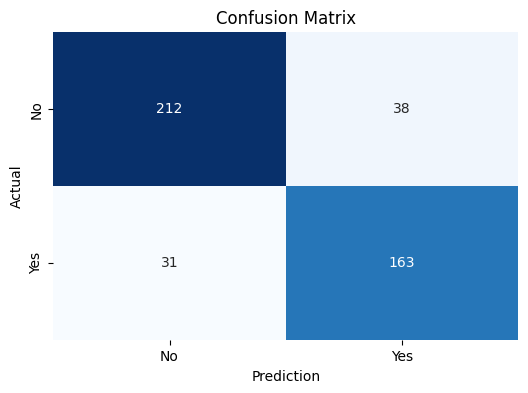

In [ ]:
# Metrics
metrics = compute_metrics(val_dataset.labels, preds)
print("Metrics:", metrics)

# Confusion matrix
conf_matrix = confusion_matrix(val_dataset.labels, preds)#, labels=["NO", "YES"])
print("\nConfusion matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(val_dataset.labels, preds, target_names=["NO", "YES"], digits=4)
print("\nReport:")
print(class_report)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [ ]:
fpositive_en, fnegative_en = false_positive_false_negative(y_true = val_dataset.labels, y_pred = preds, pred_probs = probs, texts = val_dataset.texts)

print("False positive:", len(fpositive_en))
for s in fpositive_en:
    print('**', s)

print("\n\nFalse negative:", len(fnegative_en))
for s in fnegative_en:
    print('**', s)

False positive: 38
** (0.7173093, '@Mike_Fabricant “You should smile more, love. Just pretend you’re a Tory opening a food bank. We’re only living through the worst #CostOfLivingCrisis in living memory, so it’s all a bit of a giggle. Cheer up, darling, it might never happen!”#EverydaySexism https://t.co/Y3ieWbX2Gc')
** (0.9309256, '@sage_ranae This world wouldn’t last a day without women😴')
** (0.7241087, 'An androgynous mind was not a male mind. It was a mind attuned to the full range of human experience, including the invisible lives of women.')
** (0.6785022, "@ThatBrianFella Bitch, a Maker's Mark bottle?! You'd have seen a doctor after that had been in ya.")
** (0.5245066, '@TheRightCant I mean the witcher netflix is ass, and not because sjw oe whatever (the witcher books are already anti war, pro choice, women empowerment, etc.) But the arc of yennefer is boring as shit and nilfgardian Armour looks like scrotum.')
** (0.83394164, 'This is your reminder that you can be child-free w

In [ ]:
# prompt: cargar un benchmark con el modeo y tokenizer ingles
fpositive_samples = [fpositive_en[16][1], fpositive_en[25][1], fpositive_en[28][1]]
fnegative_samples = [fnegative_en[2][1], fnegative_en[15][1], fnegative_en[25][1]]

bench_en = Benchmark(model, tokenizer)

for sample in fpositive_samples:
    print("False Positive:")
    explain_this(bench_en, sample, 1)
    print("\n\n")

for sample in fnegative_samples:
    print("False Negative:")
    explain_this(bench_en, sample, 0)
    print("\n\n")


False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: I need a MAN with this type of ENERGY ‼️#JuicyThroatXperience 🤤👅💦 https://t.co/RUL3kMsiXv
Class: 1


Token,I,Ġneed,Ġa,ĠMAN,Ġwith,Ġthis,Ġtype,Ġof,ĠEN,ER,GY,ĠâĢ,¼,ï¸ı,#,Ju,icy,Th,ro,at,X_1,per,ience,ĠðŁ,¤_1,¤_2,ðŁĳ,ħ,ðŁ,Ĵ,¦,Ġhttps,://,t,.,co,/,R,UL,3,k,Ms,i,X_2,v
Partition SHAP,-0.01,0.05,0.14,0.17,0.04,0.03,0.03,0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,0.00,0.00,0.01,0.01,-0.00,-0.00,-0.01,-0.01,0.06,0.04,0.05,0.03,0.02,0.02,0.04,0.04,0.01,0.01,0.02,0.00,-0.02,-0.02,-0.00,-0.00,-0.01,-0.01,0.00,0.00,-0.00,-0.00
LIME,0.02,0.09,0.05,0.17,0.08,0.03,0.04,0.01,-0.03,-0.01,-0.01,0.00,-0.00,0.01,0.01,0.01,0.02,0.02,0.03,0.04,-0.01,0.03,-0.04,0.04,0.02,0.03,0.01,0.01,0.02,0.02,0.00,0.01,0.01,0.01,-0.00,0.01,-0.00,-0.00,-0.01,-0.00,-0.00,0.01,-0.01,-0.00,-0.01
Gradient,0.01,0.01,0.02,0.07,0.02,0.01,0.02,0.01,0.03,0.02,0.04,0.01,0.01,0.01,0.03,0.06,0.07,0.05,0.05,0.05,0.02,0.02,0.04,0.01,0.01,0.01,0.02,0.02,0.01,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01
Gradient (x Input),0.01,-0.03,0.05,-0.06,0.01,-0.00,0.03,0.01,-0.01,0.01,-0.00,0.01,0.01,0.02,-0.05,0.23,-0.04,0.00,0.11,0.06,0.00,0.01,0.01,0.00,-0.02,-0.01,0.02,-0.00,-0.00,0.00,-0.02,0.01,0.03,0.00,-0.00,-0.02,0.00,-0.00,0.01,-0.01,-0.01,0.01,-0.01,0.01,-0.01
Integrated Gradient,-0.07,-0.01,-0.01,-0.07,0.07,-0.01,0.00,0.00,0.04,0.03,0.07,0.01,-0.04,0.03,0.00,0.02,-0.02,0.00,0.02,-0.05,0.00,0.00,0.01,0.01,-0.02,0.01,0.07,-0.01,0.02,-0.02,0.05,-0.04,0.01,-0.02,-0.01,-0.01,0.01,0.00,-0.01,0.01,0.00,-0.01,0.01,0.02,-0.02
Integrated Gradient (x Input),-0.05,0.11,0.07,0.11,0.07,0.04,0.02,0.00,0.00,0.02,-0.01,0.01,0.00,-0.00,-0.03,0.09,-0.02,0.03,0.05,0.04,-0.00,0.01,0.01,0.02,0.00,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.00,-0.00,0.01,-0.02,-0.01,0.00,-0.01,0.01,0.01,0.01,0.01,0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.66,0.03,0.43
LIME,0.65,-0.04,0.62
Gradient,0.57,0.32,0.25
Gradient (x Input),0.45,0.62,0.05
Integrated Gradient,0.19,0.65,-0.20
Integrated Gradient (x Input),0.64,0.15,0.31





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @AquariusElayne @MissMaryMcInOR @DarbysCastle @EileenM60933733 Sharia law in the religion of Islam allows abortion before the 5th montha for Rape, Incest, Mental/Physical health, or Life of Mother is at risk. After the 5th Month, abortion allowed only to save the life of the Mother.
Class: 1


Token,@,A,qu,arius,El,ayne,Ġ@_1,Miss,Mary,Mc,In,OR,Ġ@_2,Dar,bys,Cast,le,Ġ@_3,E,ileen,M,609,337,33,ĠSharia,Ġlaw,Ġin,Ġthe_1,Ġreligion,Ġof_1,ĠIslam,Ġallows,Ġabortion_1,Ġbefore,Ġthe_2,Ġ5_1,th_1,Ġmonth,a,Ġfor,ĠRape,",_1",ĠInc,est,",_2",ĠMental,/,Physical,Ġhealth,",_3",Ġor,ĠLife,Ġof_2,ĠMother_1,Ġis,Ġat,Ġrisk,._1,ĠAfter,Ġthe_3,Ġ5_2,th_2,ĠMonth,",_4",Ġabortion_2,Ġallowed,Ġonly,Ġto,Ġsave,Ġthe_4,Ġlife,Ġof_3,Ġthe_5,ĠMother_2,._2
Partition SHAP,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.04,0.04,0.01,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.23,-0.02,0.03,0.02,0.01,-0.00,-0.00,-0.00,-0.00,-0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.05,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.02,0.02,0.02
LIME,0.00,-0.01,0.01,0.02,0.00,0.01,0.01,0.05,0.02,0.01,0.00,0.01,0.02,0.02,-0.01,0.01,0.01,0.01,0.01,-0.00,0.01,-0.00,0.00,0.02,0.07,0.01,0.01,0.00,-0.01,0.01,0.02,0.03,-0.01,0.02,0.00,0.00,-0.01,-0.00,0.01,0.02,0.18,-0.01,0.02,0.01,-0.01,-0.01,0.00,0.01,0.01,0.00,-0.01,-0.01,-0.00,0.04,0.01,0.00,0.00,0.00,0.02,-0.00,0.01,0.00,0.00,0.01,0.00,0.01,-0.00,0.01,-0.02,0.00,-0.01,0.01,-0.00,0.07,0.01
Gradient,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.04,0.01,0.01,0.01,0.02,0.01,0.03,0.01,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.06,0.01,0.04,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01
Gradient (x Input),0.01,0.00,0.01,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00,-0.02,0.00,-0.07,-0.02,-0.02,0.05,-0.01,0.00,0.01,-0.01,0.01,0.03,-0.02,0.01,0.01,-0.00,0.00,-0.02,0.00,-0.03,0.01,0.05,-0.00,-0.01,0.05,-0.03,0.01,-0.01,-0.01,0.03,0.01,0.01,-0.00,-0.01,-0.02,0.03,0.00,0.01,0.02,-0.00,0.00,0.00,-0.00,0.01,0.02,0.01,-0.00,0.00,0.00,-0.01,0.01,0.04,0.02,0.00,-0.02,0.00
Integrated Gradient,0.00,-0.01,0.01,0.02,-0.01,0.01,-0.00,0.03,0.00,0.00,-0.00,-0.01,0.01,-0.01,0.03,0.01,0.01,0.01,0.02,-0.00,-0.00,-0.02,-0.01,0.00,0.02,-0.01,0.01,0.01,-0.03,-0.00,-0.01,0.00,-0.07,-0.00,0.01,-0.01,-0.01,-0.01,-0.01,0.01,-0.00,0.01,-0.01,0.00,0.01,0.02,-0.00,0.01,0.00,0.01,-0.01,-0.02,-0.00,-0.03,0.00,0.01,-0.01,-0.01,-0.00,-0.02,0.01,-0.01,-0.01,-0.01,0.06,0.02,-0.00,0.01,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,-0.01
Integrated Gradient (x Input),0.00,0.01,0.01,0.00,0.02,0.01,0.02,0.04,0.02,0.01,0.01,0.01,0.02,0.00,0.00,0.00,0.01,0.02,0.01,0.00,0.01,0.02,0.01,0.01,0.04,0.01,0.01,0.00,0.00,0.01,0.02,0.00,0.03,0.01,0.00,0.01,-0.01,0.01,0.01,0.02,0.07,0.01,0.01,0.02,-0.00,0.02,0.01,0.01,0.01,-0.00,0.00,-0.01,-0.01,0.05,0.02,0.01,0.02,0.00,0.02,0.00,0.00,0.00,0.01,-0.00,0.04,0.02,0.01,0.01,0.02,0.01,0.03,0.01,-0.01,0.04,0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.55,-0.02,-0.04
LIME,0.57,-0.13,0.37
Gradient,0.61,0.09,-0.09
Gradient (x Input),0.34,0.39,0.09
Integrated Gradient,0.14,0.36,0.13
Integrated Gradient (x Input),0.58,-0.00,0.21





False Positive:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @UberFacts Today’s women eye makeup. And those nails too.
Class: 1


Token,@,Uber,F,acts,ĠToday,âĢ,Ļ,s,Ġwomen,Ġeye,Ġmakeup,._1,ĠAnd,Ġthose,Ġnails,Ġtoo,._2
Partition SHAP,0.00,0.02,0.01,0.05,0.00,-0.04,-0.06,0.23,0.49,0.01,-0.01,0.02,0.01,0.02,0.02,0.01,-0.01
LIME,0.00,0.05,0.05,0.01,0.01,0.03,0.04,0.02,0.64,0.01,-0.04,0.01,0.04,0.01,0.01,0.02,0.00
Gradient,0.03,0.07,0.03,0.05,0.05,0.03,0.03,0.03,0.17,0.06,0.11,0.03,0.03,0.04,0.11,0.03,0.03
Gradient (x Input),-0.00,-0.00,-0.01,0.03,0.04,-0.08,-0.14,-0.01,-0.37,-0.04,0.13,0.00,0.03,0.01,-0.03,0.02,0.01
Integrated Gradient,-0.06,0.03,0.07,0.03,0.00,0.03,0.05,-0.06,-0.10,-0.12,-0.09,-0.04,-0.06,-0.02,-0.06,0.01,0.13
Integrated Gradient (x Input),0.00,0.06,0.12,-0.01,0.09,0.02,0.01,-0.01,0.44,-0.06,0.03,-0.00,-0.00,-0.04,0.02,-0.03,-0.04


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.72,0.15,0.14
LIME,0.73,0.07,0.39
Gradient,0.73,0.26,-0.05
Gradient (x Input),0.09,0.77,-0.23
Integrated Gradient,0.26,0.78,0.14
Integrated Gradient (x Input),0.76,0.36,0.32





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @5heriBr0wn @stinkythinktank @nubbin00_ @MeganMcD411 @wellroundednut @frggystyl @HauntedJennifer @normhotchkiss At first I was scared of him. But after some stalking I found out about his artistic side. Then I realized he can be sweet and salty. Like a good treat. He gardens too.About as good as a man can get.
Class: 0


Token,@,5,her,i,Br,0,wn,Ġ@_1,st_1,ink_1,yth,ink_2,tank,Ġ@_2,n,ub,bin,00,_,Ġ@_3,Me,gan,Mc,D,411,Ġ@_4,well,rounded,nut,Ġ@_5,fr,ggy,st_2,yl,Ġ@_6,Haunted,Jennifer,Ġ@_7,norm,hot,ch,kiss,ĠAt,Ġfirst,ĠI_1,Ġwas,Ġscared,Ġof,Ġhim,._1,ĠBut,Ġafter,Ġsome,Ġstalking,ĠI_2,Ġfound,Ġout,Ġabout,Ġhis,Ġartistic,Ġside,._2,ĠThen,ĠI_3,Ġrealized,Ġhe,Ġcan_1,Ġbe,Ġsweet,Ġand,Ġsalty,._3,ĠLike,Ġa_1,Ġgood_1,Ġtreat,._4,ĠHe,Ġgardens,Ġtoo,._5,About,Ġas_1,Ġgood_2,Ġas_2,Ġa_2,Ġman,Ġcan_2,Ġget,._6
Partition SHAP,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.02,-0.03,0.00,0.00,0.00,0.00,0.07,0.16,-0.00,0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.03,-0.03,-0.02,0.00,0.00,0.00,0.00,0.01,0.04,0.04,0.02,0.01,-0.01,-0.01,-0.02,-0.02,-0.09,-0.09,-0.03,-0.03,0.01
LIME,-0.00,0.00,-0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.01,-0.01,-0.00,-0.01,0.01,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,-0.02,-0.01,-0.00,-0.00,0.00,0.00,0.01,0.01,0.00,0.01,-0.00,-0.00,0.00,-0.01,0.02,0.03,-0.03,0.01,0.00,-0.02,0.00,-0.01,0.01,0.00,0.01,0.01,0.01,-0.01,0.02,0.00,0.01,-0.01,-0.00,-0.05,0.00,0.00,-0.00,0.00,0.03,0.11,0.01,0.00,-0.01,0.01,0.01,0.01,0.00,-0.00,-0.01,-0.01,-0.05,-0.00,-0.01,0.01,-0.00,-0.00,0.01,0.02,0.04,-0.00,-0.00,-0.01,0.01,0.00,-0.01,-0.06,-0.12,0.00,-0.03,0.00
Gradient,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.02,0.01,0.00,0.01,0.01,0.00,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.03,0.01,0.05,0.01,0.01,0.01,0.01,0.03,0.01,0.02,0.05,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.04,0.01,0.01,0.01
Gradient (x Input),-0.01,0.00,0.00,0.00,0.02,0.00,0.01,0.00,-0.02,-0.03,-0.00,0.00,0.01,0.00,-0.01,-0.01,-0.01,-0.02,-0.00,0.01,-0.02,0.00,-0.00,0.00,-0.01,0.01,0.03,-0.02,0.01,0.00,-0.01,-0.01,-0.00,-0.01,0.01,0.06,0.01,0.00,0.00,-0.01,-0.02,0.03,-0.01,0.01,-0.00,0.01,-0.00,0.00,0.00,0.01,-0.01,0.02,-0.00,-0.00,-0.00,0.00,0.01,0.00,0.01,-0.02,0.01,0.01,-0.00,-0.00,-0.03,0.00,0.01,0.01,-0.02,0.00,-0.04,0.02,-0.01,-0.01,0.02,0.03,-0.01,0.00,0.01,0.04,-0.01,0.00,-0.01,-0.02,0.03,0.01,0.01,-0.01,-0.01,0.04
Integrated Gradient,0.01,-0.01,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.01,-0.01,-0.00,-0.02,-0.01,0.01,0.00,-0.00,-0.01,-0.01,-0.01,0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.03,-0.02,-0.00,0.01,0.01,-0.01,0.01,-0.01,-0.04,-0.03,0.00,0.01,-0.01,-0.02,-0.01,0.00,0.00,-0.01,0.01,0.03,0.01,-0.01,-0.00,-0.00,0.01,-0.00,-0.08,-0.01,0.00,-0.01,0.01,-0.01,-0.06,-0.02,-0.00,0.01,-0.01,-0.00,0.00,-0.00,0.01,0.02,0.00,0.00,0.01,-0.01,0.00,0.01,-0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.01,-0.00,-0.08
Integrated Gradient (x Input),-0.00,-0.01,-0.01,-0.01,0.00,0.00,-0.00,-0.01,-0.02,-0.02,-0.01,-0.01,-0.00,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.02,-0.02,-0.01,-0.01,-0.00,-0.00,0.03,0.01,-0.01,-0.01,-0.00,-0.00,0.01,-0.00,-0.01,0.05,-0.02,-0.00,0.01,-0.00,0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.02,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.03,-0.00,0.00,-0.01,0.00,0.04,0.01,0.02,0.00,-0.01,0.01,0.00,0.01,-0.00,-0.01,-0.02,-0.03,-0.00,-0.01,-0.02,-0.00,-0.01,-0.01,-0.01,-0.01,0.03,0.01,-0.01,-0.01,0.02,-0.02,0.01,-0.02,-0.01,0.01,0.01,0.12


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.54,-0.13,0.30
LIME,0.69,-0.13,0.65
Gradient,-0.08,0.13,-0.09
Gradient (x Input),0.19,-0.06,0.04
Integrated Gradient,-0.04,0.21,-0.07
Integrated Gradient (x Input),0.49,-0.11,0.35





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: Calls to clean up Parliament's laddish culture after MP's porn shame https://t.co/3AC2ArWrjF via https://t.co/LiNou8Ixhu
Class: 0


Token,C,alls,Ġto,Ġclean,Ġup,ĠParliament,'s_1,Ġl,add,ish,Ġculture,Ġafter,ĠMP,'s_2,Ġporn,Ġshame,Ġhttps_1,://_1,t_1,._1,co_1,/_1,3,AC,2,Ar,Wr,j,F,Ġvia,Ġhttps_2,://_2,t_2,._2,co_2,/_2,Li,N,ou,8,I,x,hu
Partition SHAP,0.00,0.01,0.02,0.05,-0.00,0.01,-0.00,-0.01,-0.01,-0.01,0.01,-0.03,-0.03,-0.04,-0.43,-0.10,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.01,0.00,0.00,-0.00,-0.00,-0.00,0.01,0.01,0.01,0.00,0.01,0.04,0.03,-0.01,-0.00,-0.00,0.01,0.01,-0.00,-0.00
LIME,0.00,0.01,0.01,0.04,-0.00,0.03,0.00,-0.03,0.02,0.04,0.04,-0.05,-0.04,-0.04,-0.39,-0.10,-0.01,0.00,-0.01,-0.01,0.00,0.00,0.01,0.02,0.00,-0.00,0.00,0.01,-0.01,0.02,0.01,0.01,-0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,-0.00
Gradient,0.01,0.02,0.02,0.02,0.01,0.04,0.01,0.03,0.06,0.03,0.04,0.02,0.04,0.03,0.21,0.05,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Gradient (x Input),0.02,-0.04,-0.01,-0.01,0.01,0.01,0.01,0.01,0.09,-0.06,-0.01,-0.10,-0.00,0.02,0.22,-0.00,-0.04,0.01,0.01,-0.02,-0.02,0.02,0.00,-0.02,-0.01,0.02,-0.02,-0.00,-0.00,0.01,-0.01,0.00,0.00,-0.00,0.00,0.00,-0.03,-0.01,0.00,0.02,0.03,0.00,-0.00
Integrated Gradient,0.00,-0.07,0.01,-0.02,-0.03,0.03,-0.03,0.03,-0.04,0.00,-0.02,0.00,0.09,0.07,0.10,0.03,0.01,0.02,0.01,0.01,0.00,0.02,0.01,0.00,0.01,-0.01,0.03,0.02,-0.04,0.02,-0.01,0.00,-0.03,0.02,0.00,-0.00,0.00,0.00,-0.00,-0.02,-0.00,-0.02,0.02
Integrated Gradient (x Input),0.04,-0.02,-0.00,-0.01,-0.03,-0.01,-0.02,-0.03,0.04,-0.02,-0.03,-0.08,-0.03,-0.03,-0.24,-0.09,-0.02,-0.01,-0.02,-0.01,-0.02,0.02,0.01,0.00,0.01,0.00,0.00,-0.00,-0.02,-0.03,0.01,-0.01,-0.00,0.02,-0.01,0.01,0.01,-0.00,0.01,-0.00,-0.00,-0.00,-0.01


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.19,-0.39,0.32
LIME,0.11,-0.38,0.47
Gradient,-0.35,0.02,-0.21
Gradient (x Input),-0.38,-0.07,-0.10
Integrated Gradient,-0.39,0.06,-0.31
Integrated Gradient (x Input),-0.01,-0.33,0.31





False Negative:


Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

Sentence: @djxmenez yea back when i didn’t even have one to slap, unfortunate !
Class: 0


Token,@,dj,x,m,enez,Ġyea,Ġback,Ġwhen,Ġi,Ġdidn,âĢ,Ļ,t,Ġeven,Ġhave,Ġone,Ġto,Ġslap,",",Ġunfortunate,Ġ!
Partition SHAP,0.02,0.08,0.03,-0.01,0.05,0.00,0.02,-0.01,-0.01,0.02,-0.00,0.01,-0.02,-0.01,0.07,0.03,-0.10,-0.42,0.03,0.05,0.03
LIME,0.00,0.03,0.02,-0.01,0.04,-0.02,-0.04,-0.06,0.08,0.00,-0.04,-0.03,0.01,-0.03,0.01,0.10,-0.07,-0.31,-0.01,0.05,-0.03
Gradient,0.03,0.04,0.02,0.02,0.03,0.04,0.03,0.03,0.03,0.02,0.01,0.02,0.02,0.02,0.03,0.05,0.06,0.25,0.05,0.07,0.03
Gradient (x Input),-0.05,0.07,0.06,-0.02,-0.14,0.15,0.04,-0.00,-0.02,0.02,0.02,-0.01,-0.00,-0.06,-0.00,-0.08,0.09,-0.02,0.05,-0.07,-0.04
Integrated Gradient,0.06,0.09,0.04,0.02,0.04,0.04,0.02,0.00,-0.11,0.00,0.02,0.03,0.04,0.08,-0.02,-0.07,0.10,-0.09,0.03,0.01,0.06
Integrated Gradient (x Input),-0.01,-0.00,0.01,-0.04,-0.09,0.02,0.01,0.00,0.03,0.03,0.01,0.01,-0.01,-0.02,-0.00,0.02,-0.18,-0.35,0.05,0.07,0.03


,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.18,-0.16,0.51
LIME,0.23,-0.13,0.71
Gradient,-0.12,-0.02,0.05
Gradient (x Input),-0.08,-0.12,-0.20
Integrated Gradient,-0.09,-0.14,-0.12
Integrated Gradient (x Input),0.10,-0.15,0.25
